In [54]:
pip install catboost

In [55]:
!pip install scikit-optimize

In [56]:
!pip install scikeras

In [57]:
# ====================================
# 1. Imports & Global Settings
# ====================================
import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef,
    roc_curve, precision_recall_curve, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from skopt import BayesSearchCV



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

In [58]:
# ============================
# 2. Load & Basic EDA
# ============================
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/creditcard.csv")
print("Raw shape:", df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw shape: (284807, 31)


In [59]:
print("\nClass distribution:")
print(df['Class'].value_counts(), "\n")
print("Class ratio:")
print(df['Class'].value_counts(normalize=True))


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64 

Class ratio:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [60]:
# Remove duplicates & NaNs
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283726 entries, 0 to 283725
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21


Sample shape: (28373, 31)
                Time            V1            V2            V3            V4  \
count   28373.000000  28373.000000  28373.000000  28373.000000  28373.000000   
mean    94564.332323      0.004300     -0.003840      0.001549     -0.007872   
std     47376.490678      1.932902      1.650566      1.521519      1.412812   
min         0.000000    -35.548539    -60.464618    -48.325589     -5.401678   
25%     53849.000000     -0.927559     -0.602418     -0.880092     -0.861837   
50%     84585.000000      0.002275      0.062558      0.177949     -0.019246   
75%    138898.000000      1.317587      0.797430      1.017514      0.731128   
max    172784.000000      2.420064     17.930550      4.069865     16.875344   

                 V5            V6            V7            V8            V9  \
count  28373.000000  28373.000000  28373.000000  28373.000000  28373.000000   
mean       0.000308     -0.012293      0.011225      0.009624     -0.007141   
std        1.49

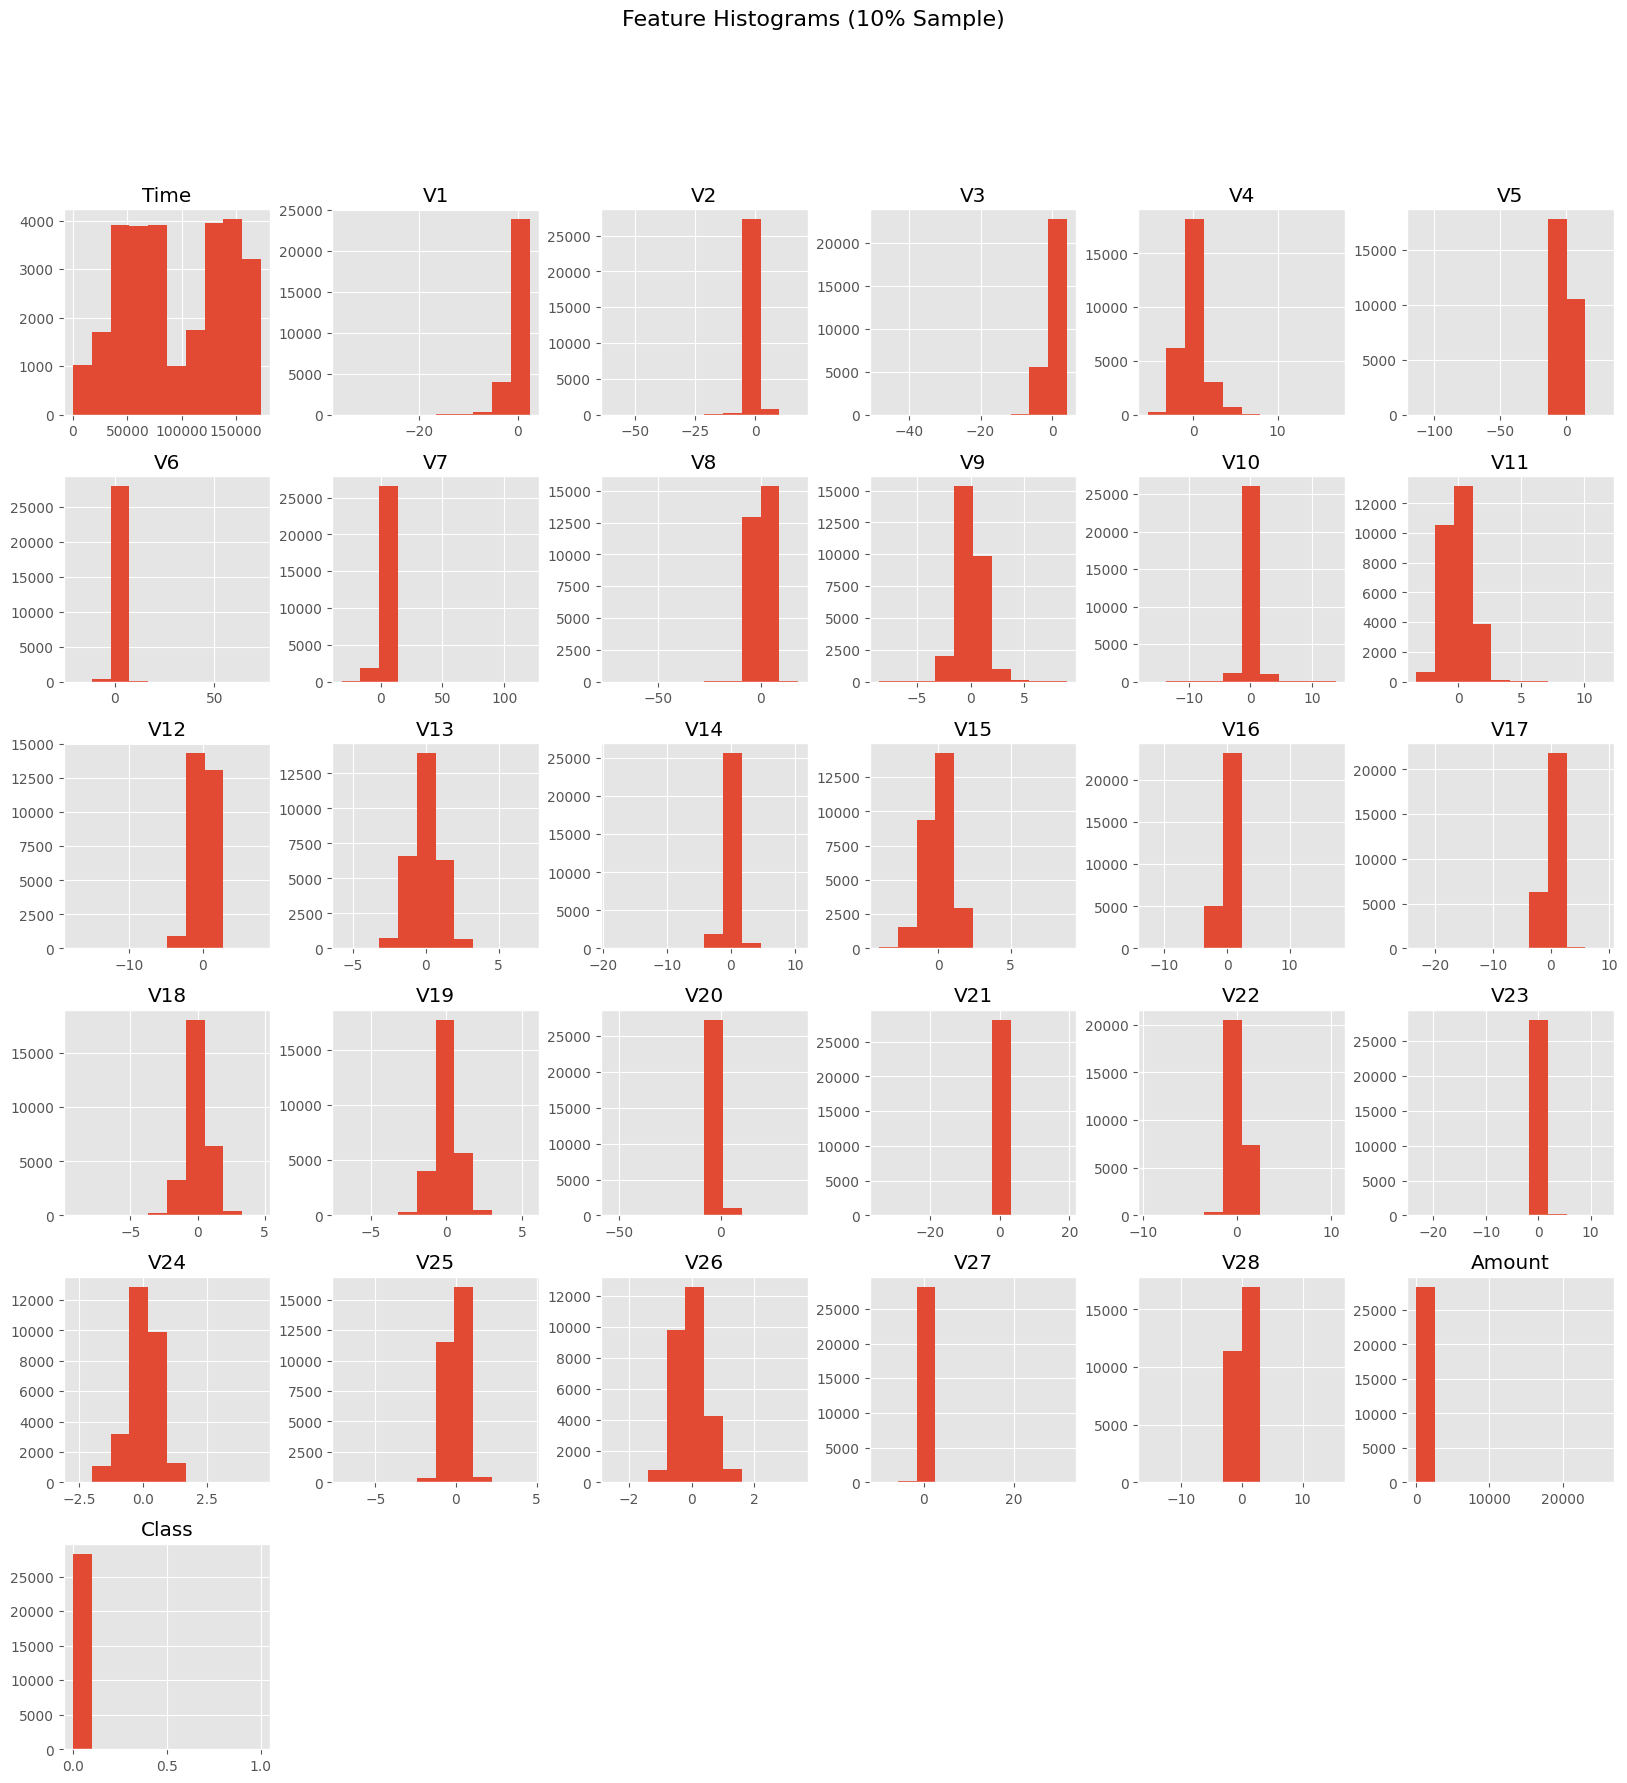

In [61]:
# ====================================
# 3. Sample for EDA (10%) & Histograms
# ====================================
df_samp = df.sample(frac=0.1, random_state=1)
print("\nSample shape:", df_samp.shape)
print(df_samp.describe())

df_samp.hist(figsize=(20,20))
plt.suptitle("Feature Histograms (10% Sample)", fontsize=16)
plt.show()

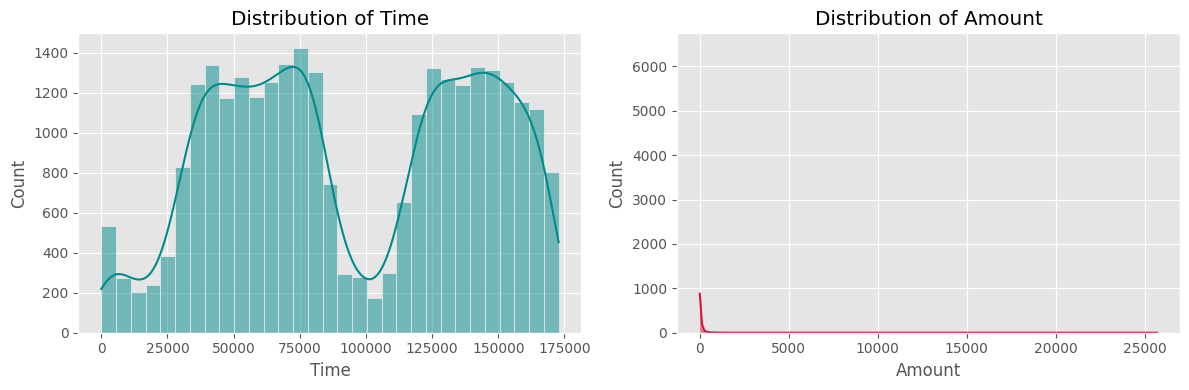

In [62]:
# ====================================
# 4. Time & Amount Distribution
# ====================================
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
sns.histplot(df_samp['Time'],    kde=True, ax=ax1, color='#008B8B')
sns.histplot(df_samp['Amount'],  kde=True, ax=ax2, color='#DC143C')
ax1.set_title("Distribution of Time")
ax2.set_title("Distribution of Amount")
plt.tight_layout()
plt.show()

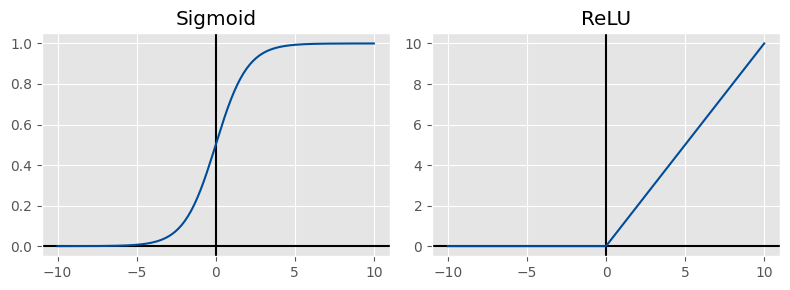

In [63]:
# ====================================
# 5. Activation Function Plot
# ====================================
def sigmoid(x): return 1/(1+np.exp(-x))
def relu(x):    return np.maximum(x, 0., None)
fig, axes = plt.subplots(1,2,figsize=(8,3), dpi=100)
x = np.linspace(-10,10,200)
for ax in axes:
    ax.axhline(0, color='k'); ax.axvline(0, color='k')

axes[0].plot(x, sigmoid(x), color='#004c99')
axes[0].set_title("Sigmoid"); axes[0].grid(True)
axes[1].plot(x, relu(x),    color='#004c99')
axes[1].set_title("ReLU");    axes[1].grid(True)
plt.tight_layout()
plt.show()

In [64]:
# 6.Feature engineering: hour & second from Time
df['hour']   = ((df['Time'] // 3600) // 2).astype(int)
df['second'] = (df['Time'] % 3600).astype(int)
df.drop('Time', axis=1, inplace=True)



Class counts:
 Class
0    283253
1       473
Name: count, dtype: int64

Class ratio:
 Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


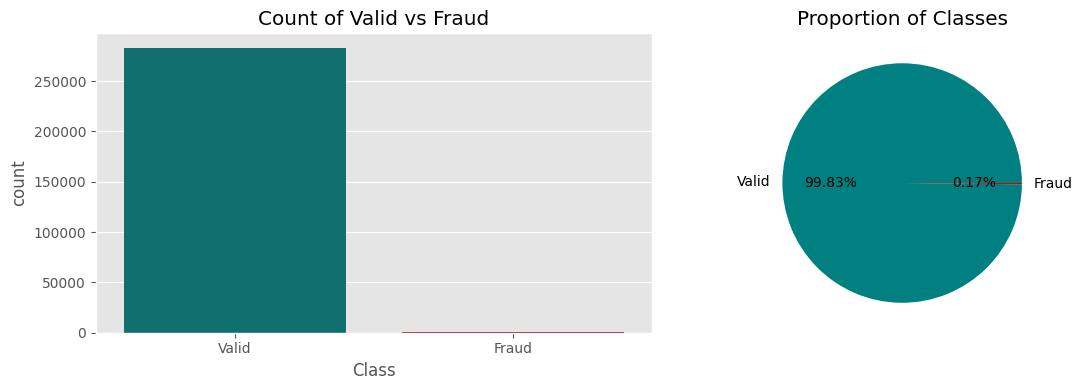

In [65]:
# 7. Class Balance Plots
# ====================================
print("\nClass counts:\n", df['Class'].value_counts())
print("\nClass ratio:\n", df['Class'].value_counts(normalize=True))

fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.countplot(x='Class', data=df, palette=['#008080','#CC0000'], ax=axes[0])
axes[0].set_xticklabels(['Valid','Fraud'])
axes[0].set_title("Count of Valid vs Fraud")

axes[1].pie(
    df['Class'].value_counts(),
    labels=['Valid','Fraud'],
    autopct='%.2f%%',
    colors=['#008080','#CC0000']
)
axes[1].set_title("Proportion of Classes")
plt.tight_layout()
plt.show()

In [66]:
# ====================================
# 8. Train/Test Split & Scaling
# ====================================
X = df.drop('Class', axis=1)
y = df['Class']

# Robust scale Amount
rob = RobustScaler()
X['Amount'] = rob.fit_transform(X[['Amount']])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nTrain/Test split:", X_train.shape, X_test.shape)


Train/Test split: (226980, 31) (56746, 31)


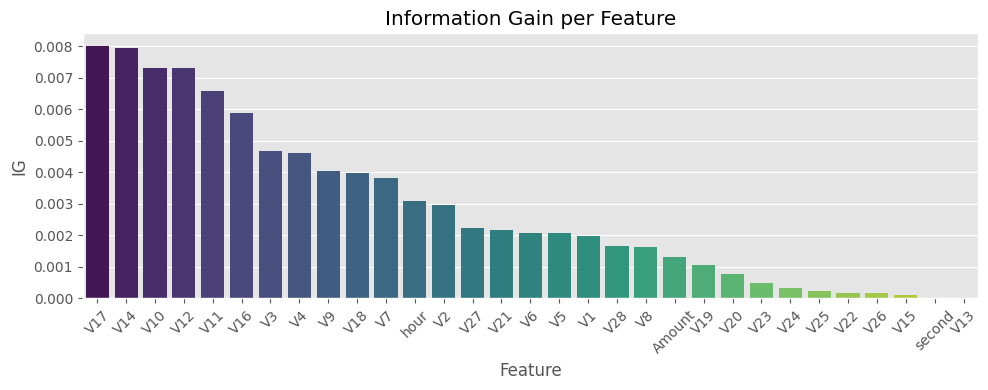

Top 6 features: ['V17', 'V14', 'V10', 'V12', 'V11', 'V16']


In [67]:
# ====================================
# 9. Feature Selection (Information Gain)
# ====================================
ig = mutual_info_classif(X_train, y_train)
feat_df = pd.DataFrame({'Feature':X.columns, 'IG':ig}).sort_values('IG', ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x='Feature', y='IG', data=feat_df, palette='viridis')
plt.xticks(rotation=45)
plt.title("Information Gain per Feature")
plt.tight_layout()
plt.show()

top_feats = feat_df['Feature'].head(6).tolist()
print("Top 6 features:", top_feats)

X_train_sel = X_train[top_feats]
X_test_sel  = X_test[top_feats]

In [68]:
# ====================================
# 10. CV Definition & Scoring
# ====================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy':'accuracy', 'precision':'precision',
    'recall':'recall', 'f1':'f1', 'roc_auc':'roc_auc',
    'mcc': make_scorer(matthews_corrcoef)
}

def cv_eval(model):
    res = cross_validate(model, X_train_sel, y_train,
                         cv=cv, scoring=scoring, n_jobs=-1)
    return {k: np.mean(v) for k,v in res.items() if k.startswith('test_')}

In [69]:

# ====================================
# 11. Base Models CV
# ====================================
base_models = {
  'LogisticReg': LogisticRegression(class_weight='balanced', solver='liblinear'),
  'LightGBM':     LGBMClassifier(class_weight='balanced', random_state=42),
  'XGBoost':      XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1],
                                random_state=42),
  'CatBoost':     CatBoostClassifier(auto_class_weights='Balanced', verbose=0,
                                     random_state=42)
}

cv_results = {}
for name, mdl in base_models.items():
    print(f"CV {name}...", end='')
    scores = cv_eval(mdl)
    # strip 'test_' prefix
    cv_results[name] = {m: scores[f'test_{m}'] for m in scoring}
    print(" done")

cv_df = pd.DataFrame(cv_results).T
cv_df.columns = cv_df.columns.str.replace('test_','')
print("\n--- 5‑Fold CV Base Models ---")
print(cv_df)

CV LogisticReg... done
CV LightGBM... done
CV XGBoost... done
CV CatBoost... done

--- 5‑Fold CV Base Models ---
             accuracy  precision    recall        f1   roc_auc       mcc
LogisticReg  0.978011   0.063565  0.883614  0.118552  0.967008  0.233507
LightGBM     0.999150   0.709118  0.841263  0.767684  0.964701  0.771008
XGBoost      0.999401   0.819390  0.822807  0.820322  0.963300  0.820411
CatBoost     0.999132   0.708587  0.830702  0.762499  0.959118  0.765634


In [70]:
# ====================================
# 12. Bayesian Opt. for LightGBM
# ====================================
opt = BayesSearchCV(
    LGBMClassifier(random_state=42),
    {
      'num_leaves':(20,150),
      'max_depth':(3,15),
      'learning_rate':(1e-3,0.2,'log-uniform'),
      'n_estimators':(50,300)
    },
    n_iter=20, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42
)
print("\nBayesOpt LightGBM...", end='')
opt.fit(X_train_sel, y_train)
best_lgb = opt.best_estimator_
cv_results['Opt_LightGBM'] = cv_eval(best_lgb)
print(" done. Params:", opt.best_params_)


BayesOpt LightGBM...[LightGBM] [Info] Number of positive: 378, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 226980, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001665 -> initscore=-6.396056
[LightGBM] [Info] Start training from score -6.396056
 done. Params: OrderedDict([('learning_rate', 0.006590662201237915), ('max_depth', 10), ('n_estimators', 300), ('num_leaves', 20)])


In [71]:
# ====================================
# 13. Voting Ensembles CV
# ====================================
v_defs = {
  'Vote_L+X+C': [('LightGBM', base_models['LightGBM']),
                 ('XGBoost', base_models['XGBoost']),
                 ('CatBoost', base_models['CatBoost'])],
  'Vote_L+X'  : [('LightGBM', base_models['LightGBM']),
                 ('XGBoost', base_models['XGBoost'])],
  'Vote_L+C'  : [('LightGBM', base_models['LightGBM']),
                 ('CatBoost', base_models['CatBoost'])],
  'Vote_X+C'  : [('XGBoost', base_models['XGBoost']),
                 ('CatBoost', base_models['CatBoost'])]
}

for name, ests in v_defs.items():
    vc = VotingClassifier(estimators=ests, voting='soft')
    print(f"CV {name}...", end='')
    cv_results[name] = cv_eval(vc)
    print(" done")

CV Vote_L+X+C... done
CV Vote_L+X... done
CV Vote_L+C... done
CV Vote_X+C... done


In [72]:
# ====================================
# 14. Deep Learning: Manual CV
# ====================================
def build_ann():
    m = Sequential([
      Dense(86, activation='relu', input_shape=(X_train_sel.shape[1],)),
      Dense(64, activation='relu'),
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
    return m

def manual_cv_dl():
    accs, precs, recs, f1s, mccs, rocs = [],[],[],[],[],[]
    X_arr, y_arr = X_train_sel.values, y_train.values
    for tr, va in cv.split(X_arr, y_arr):
        m = build_ann()
        m.fit(X_arr[tr], y_arr[tr], epochs=10, batch_size=1563, verbose=0)
        p = (m.predict(X_arr[va])>0.5).astype(int).flatten()
        pr = m.predict(X_arr[va]).flatten()
        accs.append(accuracy_score(y_arr[va],p))
        precs.append(precision_score(y_arr[va],p))
        recs.append(recall_score(y_arr[va],p))
        f1s.append(f1_score(y_arr[va],p))
        mccs.append(matthews_corrcoef(y_arr[va],p))
        rocs.append(roc_auc_score(y_arr[va],pr))
    return {
      'accuracy':np.mean(accs),
      'precision':np.mean(precs),
      'recall':np.mean(recs),
      'f1':np.mean(f1s),
      'mcc':np.mean(mccs),
      'roc_auc':np.mean(rocs)
    }

print("CV Deep Learning...", end='')
cv_results['Deep_Learning'] = manual_cv_dl()
print(" done\n")

# ——— Clean up cv_results keys and build a tidy DataFrame ———
cv_clean = {}
for model_name, scores in cv_results.items():
    normalized = {}
    for metric_name, value in scores.items():
        # strip any 'test_' prefix
        clean_name = metric_name.replace('test_', '')
        normalized[clean_name] = value
    cv_clean[model_name] = normalized

cv_df = pd.DataFrame(cv_clean).T
print("=== Full 5‑Fold CV Summary (cleaned) ===")
print(cv_df)


1419/1419 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 done

=== Full 5‑Fold CV Summary (cleaned) ===
               accuracy  precision    recall        f1   roc_auc       mcc
LogisticReg    0.978011   0.063565  0.883614  0.118552  0.967008  0.233507
LightGBM       0.999150   0.709118  0.841263  0.767684  0.964701  0.771008
XGBoost        0.999401   0.819390  0.822807  0.820322  0.963300  0.820411
CatBoost       0.999132   0.708587  0.830702  0.762499  0.959118  0.765634
Opt_LightGBM   0.999414   0.863188  0.772526  0.812645  0.970840  0.814955
Vote_L+X+C     0.999339   0.786075  0.833368  0.807709  0.966090  0.8083

[LightGBM] [Info] Number of positive: 303, number of negative: 181281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 181584, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 303, number of negative: 181281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 181584, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [In

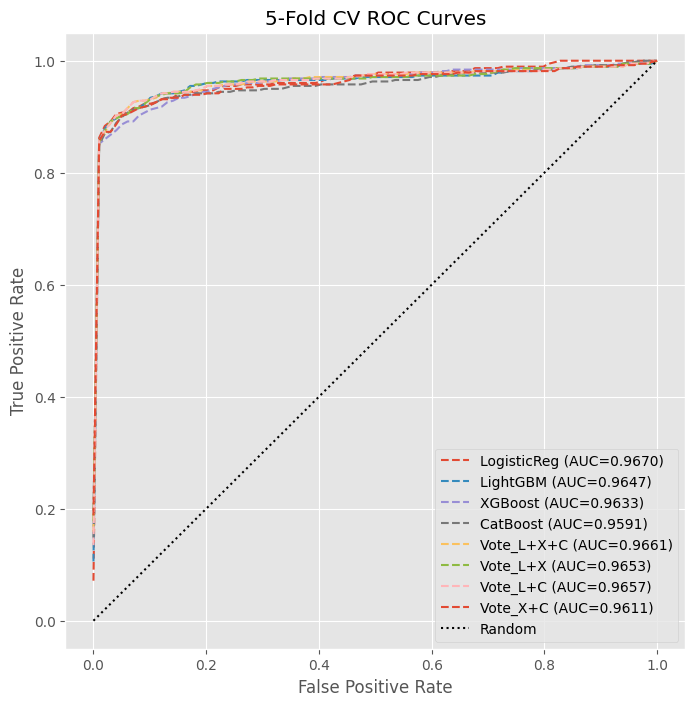

In [73]:
# 15. 5‑Fold CV ROC Curves (all eight models)
# ——— combine base + voting models into one dict ———
all_models = {}
all_models.update(base_models)
for name, ests in v_defs.items():
    all_models[name] = VotingClassifier(estimators=ests, voting='soft')
# 5‑Fold CV ROC Curves (all eight models)
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))

for name, mdl in all_models.items():
    tprs, aucs = [], []
    for tr, va in cv.split(X_train_sel, y_train):
        mdl.fit(X_train_sel.iloc[tr], y_train.iloc[tr])
        prob = mdl.predict_proba(X_train_sel.iloc[va])[:, 1]
        fpr, tpr, _ = roc_curve(y_train.iloc[va], prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc_score(y_train.iloc[va], prob))

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    plt.plot(
      mean_fpr, mean_tpr,
      linestyle='--',
      label=f"{name} (AUC={mean_auc:.4f})"
    )

plt.plot([0, 1], [0, 1], 'k:', label='Random')
plt.title("5‑Fold CV ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


[LightGBM] [Info] Number of positive: 303, number of negative: 181281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 181584, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 303, number of negative: 181281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 181584, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [In

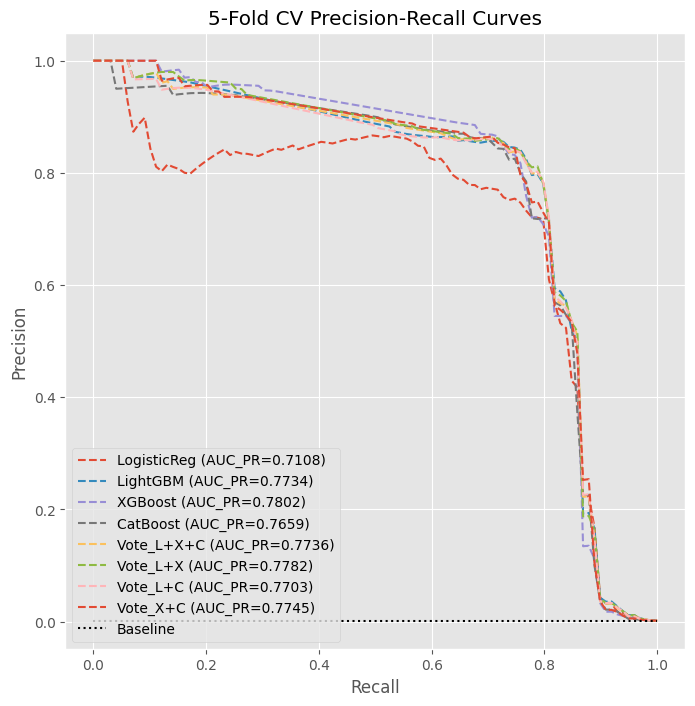

In [74]:
# 16. 5‑Fold CV Precision‑Recall (all eight models)
mean_rec = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))

for name, mdl in all_models.items():
    precisions = []
    for tr, va in cv.split(X_train_sel, y_train):
        mdl.fit(X_train_sel.iloc[tr], y_train.iloc[tr])
        prob = mdl.predict_proba(X_train_sel.iloc[va])[:, 1]
        p, r, _ = precision_recall_curve(y_train.iloc[va], prob)
        # interp to fixed recall grid
        precisions.append(np.interp(mean_rec, r[::-1], p[::-1]))

    mean_prec = np.mean(precisions, axis=0)
    pr_auc = np.trapz(mean_prec, mean_rec)
    plt.plot(
      mean_rec, mean_prec,
      linestyle='--',
      label=f"{name} (AUC_PR={pr_auc:.4f})"
    )

plt.plot([0, 1], [np.mean(y_train), np.mean(y_train)], 'k:', label='Baseline')
plt.title("5‑Fold CV Precision‑Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


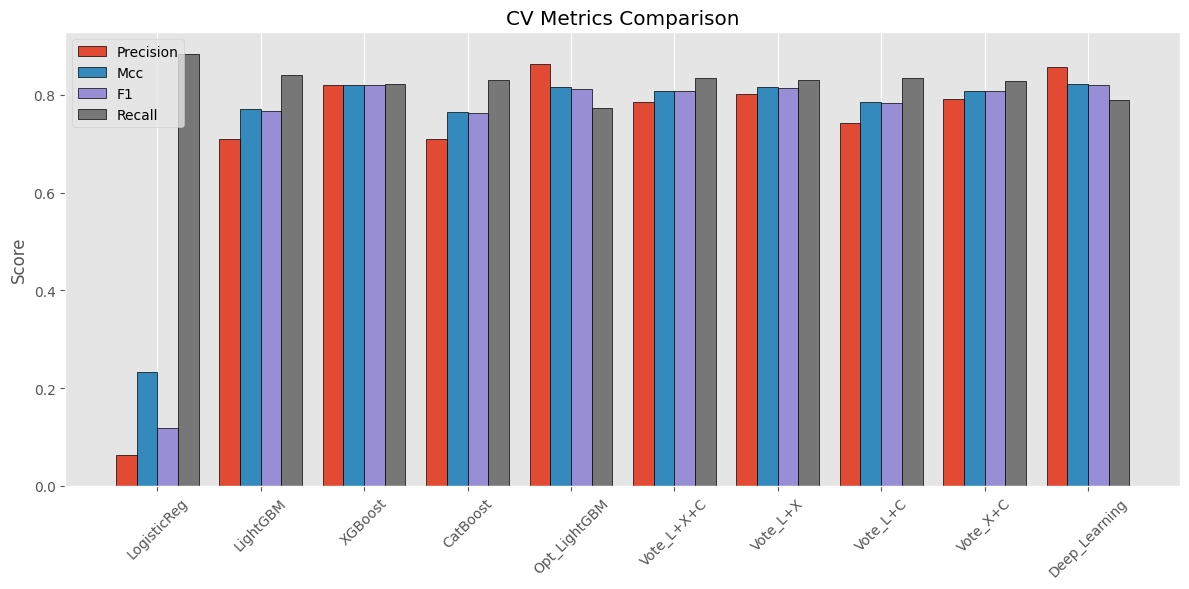

In [75]:
# ====================================
# 17. CV Bar Chart of Metrics
# ====================================
metrics = ['precision','mcc','f1','recall']
x = np.arange(len(cv_df))
width = 0.2

plt.figure(figsize=(12,6))
for i, m in enumerate(metrics):
    plt.bar(x + i*width, cv_df[m], width, label=m.capitalize(),
            edgecolor='black')

plt.xticks(x+1.5*width, cv_df.index, rotation=45)
plt.ylabel("Score"); plt.title("CV Metrics Comparison")
plt.legend(); plt.grid(axis='y')
plt.tight_layout()
plt.show()


1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


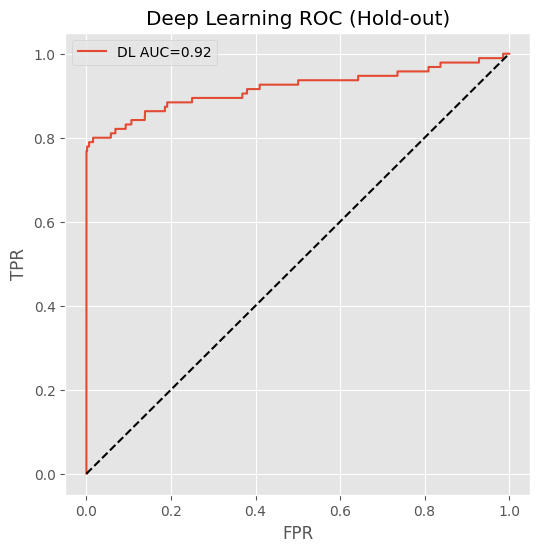

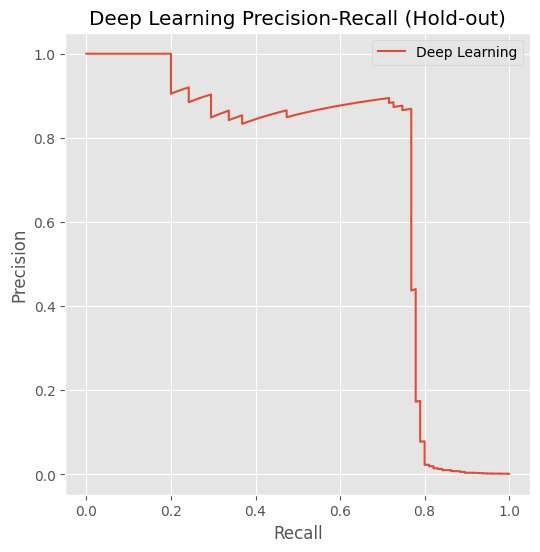

In [76]:
# ====================================
# 18. Deep Learning ROC & PR (Hold‑out)
# ====================================
# Fit DL on full train, then plot on test
dl_final = build_ann()
dl_final.fit(X_train_sel, y_train, epochs=10, batch_size=1563, verbose=0)
p_test = dl_final.predict(X_test_sel).flatten()
fpr_dl, tpr_dl, _ = roc_curve(y_test, p_test)
prec_dl, rec_dl, _ = precision_recall_curve(y_test, p_test)

plt.figure(figsize=(6,6))
plt.plot(fpr_dl, tpr_dl, label=f"DL AUC={roc_auc_score(y_test,p_test):.2f}")
plt.plot([0,1],[0,1],'k--')
plt.title("Deep Learning ROC (Hold‑out)")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(rec_dl, prec_dl, label="Deep Learning")
plt.title("Deep Learning Precision‑Recall (Hold‑out)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.grid(True)
plt.show()